# Setup

In [ ]:
!pip install wandb

import wandb
wandb.login()

wandb: Currently logged in as: sanchitv7 (sanchitv7-university-of-surrey). Use `wandb login --relogin` to force relogin


True

In [ ]:
%env WANDB_PROJECT=video_classification
%env WANDB_LOG_MODEL="checkpoint"

env: WANDB_PROJECT=video_classification
env: WANDB_LOG_MODEL="checkpoint"


In [ ]:
%%capture
import importlib

def install_if_missing(package_name):
    try:
        importlib.import_module(package_name)
        print(f"'{package_name}' is already installed.")
    except ImportError:
        print(f"'{package_name}' not found. Installing...")
        !pip install {package_name}


install_if_missing('evaluate')
install_if_missing('datasets')
install_if_missing('torchsummary')

In [ ]:
dataset_zip = 'BVIArtefact_8_crops_all_videos'

In [ ]:
import os

if os.getcwd() != '/content':
    %cd /content

if not os.path.isdir('/content/data'):
    !mkdir data

if not os.path.isdir(f'/content/data/{dataset_zip}'):
    !scp /content/drive/MyDrive/MSProjectMisc/{dataset_zip}.zip .
    !unzip -q {dataset_zip}.zip

    !rm -rf /content/__MACOSX
    !mv {dataset_zip}/ data/
    !rm -rf {dataset_zip}.zip
    %cd /content/data/{dataset_zip}
    !pwd
    !find ./train ./val ./test -name "._*" -type f -delete

    %cd ../
    %cd ../

In [ ]:
# @title # Set Seed
import random
import numpy as np
import torch
import transformers

def set_seed(seed: int = 42):
    """
    Set seeds for reproducibility.

    Args:
        seed (int): The seed to set for all random number generators.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set seed for Hugging Face transformers
    transformers.set_seed(seed)

# At the start of your script
set_seed(42)

In [ ]:
# @title #Dataset Declaration
import torch
import os
import json
from torch.utils.data import Dataset
from typing import Dict, List
from torchvision import transforms

class BVIArtefactDataset(Dataset):
    def __init__(self, root_dir: str, split: str = 'train'):
        self.root_dir = os.path.join(root_dir, split)
        self.labels_file = os.path.join(self.root_dir, 'labels.json')
        self.crop_files = [f for f in os.listdir(self.root_dir) if f.endswith('.pt')]
        with open(self.labels_file, 'r') as f:
            self.labels = json.load(f)
        self.label_names = list(next(iter(self.labels.values())).keys())
        self.id2label = {i: label for i, label in enumerate(self.label_names)}
        self.label2id = {label: i for i, label in self.id2label.items()}
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10)
        ]) if split == 'train' else None

    def __len__(self):
        return len(self.crop_files)

    def __getitem__(self, idx):
        crop_file = self.crop_files[idx]
        crop_path = os.path.join(self.root_dir, crop_file)
        # load video crops
        video = torch.load(crop_path,
                           map_location='cpu',
                           weights_only=False)
        # Get labels
        label_dict = self.labels[crop_file]
        labels = torch.tensor([label_dict[name] for name in self.label_names], dtype=torch.float32)
        return {"pixel_values": video, "labels": labels}

    def get_label_mappings(self):
        return self.id2label, self.label2id

# Inspect Dataset

In [ ]:
from pprint import pprint
# Create datasets
root_dir = f'data/{dataset_zip}'
train_dataset = BVIArtefactDataset(root_dir, split='train')
val_dataset = BVIArtefactDataset(root_dir, split='val')
test_dataset = BVIArtefactDataset(root_dir, split='test')

# Check the shape of an item
print('Shape of one patch of a video:')
print(train_dataset[0]['pixel_values'].shape)  # Should print torch.Size([8, 3, 224, 224])
print()
print('Shape of the label:')
print(train_dataset[0]['labels'].shape)  # Should print torch.Size([num_labe

id2label, label2id = BVIArtefactDataset(root_dir, split='train').get_label_mappings()

num_labels = len(id2label)

print(f'\nindex to label mapping:')
pprint(id2label)
print()
print(f'label to index mapping:')
pprint(label2id)

Shape of one patch of a video:
torch.Size([8, 3, 224, 224])

Shape of the label:
torch.Size([9])

index to label mapping:
{0: 'black_screen',
 1: 'frame_drop',
 2: 'spatial_blur',
 3: 'transmission_error',
 4: 'aliasing',
 5: 'banding',
 6: 'dark_scenes',
 7: 'graininess',
 8: 'motion_blur'}

label to index mapping:
{'aliasing': 4,
 'banding': 5,
 'black_screen': 0,
 'dark_scenes': 6,
 'frame_drop': 1,
 'graininess': 7,
 'motion_blur': 8,
 'spatial_blur': 2,
 'transmission_error': 3}


In [ ]:
train_dataset[0]['labels']

tensor([0., 1., 0., 0., 0., 0., 0., 1., 1.])

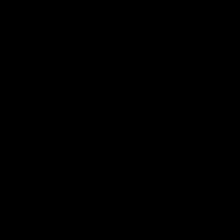

{'aliasing': tensor(0.),
 'banding': tensor(1.),
 'black_screen': tensor(1.),
 'dark_scenes': tensor(0.),
 'frame_drop': tensor(1.),
 'graininess': tensor(0.),
 'motion_blur': tensor(0.),
 'spatial_blur': tensor(0.),
 'transmission_error': tensor(1.)}


In [ ]:
import imageio
import numpy as np
from IPython.display import Image, display
import torch
import random

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = (img * std) + mean
    img = (img * 255).clamp(0, 255).byte()
    return img

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame).permute(1, 2, 0).numpy()
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

# Get a sample from your dataset
random_sample = random.randint(0, len(train_dataset))

sample = train_dataset[random_sample]
video_tensor = sample['pixel_values']

# Display the GIF
display(display_gif(video_tensor, "sample_crop.gif"))
pprint({id2label[i]: sample['labels'][i] for i in range(len(sample['labels']))})

In [ ]:
# @title # Utility Functions
import datetime
import os
import json
from typing import Dict, Any
import pytz

# Set the timezone to UTC+1
timezone = pytz.timezone('Europe/London')  # This is an example; choose a timezone with UTC+1


def get_run_name():
    # Generate a timestamp
    timestamp = datetime.datetime.now(timezone).strftime("%Y-%m-%d--%H-%M-%S")

    # Create a unique run name
    run_name = f"run-{timestamp}"

    # Create directories for this run
    os.makedirs(f"./logs/{run_name}", exist_ok=True)
    os.makedirs(f"./results/{run_name}", exist_ok=True)

    return run_name


def log_run_info(run_name, model, training_args):

    run_info_path = os.path.join("./logs", run_name, "run_info.txt")
    with open(run_info_path, "w") as f:
        f.write(f"Run Name: {run_name}\n")
        f.write(f"Model: {type(model).__name__}\n")
        f.write("Training Arguments:\n")
        for arg, value in vars(training_args).items():
            f.write(f"  {arg}: {value}\n")


def save_test_results_to_json(test_results: Dict[str, Any], artifacts: list):
    """
    Format test results and save them to a JSON file.

    Args:
    test_results (Dict[str, Any]): Dictionary containing test results
    artifacts (list): List of artifact names
    output_file (str): Path to the output JSON file
    """

    output_file = os.path.join("./logs", run_name, "test_set_results.json")

    # formatted_results = {
    #     "overall_metrics": {
    #         "loss": test_results['eval_loss'],
    #         "accuracy": test_results['eval_accuracy'],
    #         "f1_score": test_results['eval_f1'],
    #         "auc": test_results['eval_auc'],
    #         "combined_auc_focus": test_results['source_artefacts_avg_auc']
    #     },
    #     "artifact_metrics": {},
    #     "additional_info": {
    #         "runtime": test_results['eval_runtime'],
    #         "samples_per_second": test_results['eval_samples_per_second'],
    #         "steps_per_second": test_results['eval_steps_per_second'],
    #         "epoch": test_results['epoch']
    #     }
    # }

    # for artifact in artifacts:
    #     formatted_results["artifact_metrics"][artifact] = {
    #         "accuracy": test_results[f'eval_accuracy_{artifact}'],
    #         "f1_score": test_results[f'eval_f1_{artifact}'],
    #         "auc": test_results[f'eval_auc_{artifact}']
    #     }

    with open(output_file, 'w') as f:
        json.dump(test_results, f, indent=2)

    print(f"Test results saved to {output_file}")

# Function to print metrics for a specific artifact
def print_artifact_metrics(artifact, metrics):
    print(f"\n{artifact.capitalize()} Metrics:")
    print(f"  Accuracy: {metrics[f'eval_accuracy_{artifact}']:.4f}")
    print(f"  F1 Score: {metrics[f'eval_f1_{artifact}']:.4f}")
    print(f"  AUC:      {metrics[f'eval_auc_{artifact}']:.4f}")

In [ ]:
# @title # Model Declaration

import torch
import torch.nn as nn
from transformers import TimesformerModel
from torch.nn import functional as F


def focal_loss(logits, labels, alpha=0.25, gamma=2.0):
    """
    Focal loss for multi-label classification.
    """
    BCE_loss = F.binary_cross_entropy_with_logits(logits, labels, reduction='none')
    pt = torch.exp(-BCE_loss)
    focal_loss = alpha * (1-pt)**gamma * BCE_loss
    return focal_loss.mean()


class MultiTaskTimeSformer(nn.Module):
    def __init__(self, num_labels, id2label, label2id, dataset, num_layers_to_finetune=4):
        """
        Multi-task TimeSformer model for video artifact detection.

        Args:
        num_labels: Number of artifact classes
        id2label: Mapping from label index to label name
        label2id: Mapping from label name to label index
        dataset: Dataset used for calculating initial weights
        num_layers_to_finetune: Number of layers to fine-tune in the TimeSformer backbone
        """
        super().__init__()
        self.num_labels = num_labels
        self.id2label = id2label
        self.label2id = label2id

        # TimeSformer backbone
        # Using a pre-trained model for transfer learning
        self.timesformer = TimesformerModel.from_pretrained(
            "facebook/timesformer-base-finetuned-k400",
            ignore_mismatched_sizes=True
        )

        # Task-specific adaptation layers
        # These layers adapt the TimeSformer's output for each specific artifact detection task
        # self.task_adapters = nn.ModuleDict({
        #     label: nn.Sequential(
        #         nn.Linear(768, 512),
        #         nn.ReLU(),
        #         nn.Dropout(0.1),  # Dropout for regularization
        #         nn.Linear(512, 256),
        #         nn.ReLU(),
        #         nn.Dropout(0.1),
        #         nn.Linear(256, 1)
        #     ) for label in id2label.values()
        # })

        self.task_adapters = nn.ModuleDict({
            label: nn.Sequential(
                nn.Linear(768, 512),
                nn.LayerNorm(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.LayerNorm(256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(128, 1)
            ) for label in id2label.values()
        })

        # self.task_adapters = nn.ModuleDict({
        #     label: nn.Sequential(
        #         nn.Linear(768, 256),
        #         nn.LayerNorm(256), # Layer Normalisatoin
        #         nn.ReLU(),
        #         nn.Dropout(0.3),  # Dropout for regularization
        #         nn.Linear(256, 1)
        #     ) for label in id2label.values()
        # })

        # Calculate and set initial task weights
        # This helps address class imbalance from the start of training
        initial_weights = self.calculate_initial_weights(dataset)
        # self.class_weights = nn.Parameter(initial_weights, requires_grad=False)
        self.task_weights = nn.Parameter(initial_weights)

        # Freeze all layers except the last few
        # This allows for fine-tuning of the model while preserving pre-trained knowledge
        self.freeze_layers(num_layers_to_finetune)

    def calculate_initial_weights(self, dataset):
        """
        Calculate class weights based on class frequencies and positive/negative ratios.
        This helps address class imbalance in multi-label classification.

        Args:
        dataset: The dataset containing labels

        Returns:
        combined_weights: Tensor of weights for each class
        """
        num_samples = len(dataset)
        num_labels = len(dataset.id2label)

        class_frequencies = torch.zeros(num_labels)
        pos_neg_ratios = torch.zeros(num_labels)

        # Calculate class frequencies
        for i in range(num_samples):
            labels = dataset[i]['labels']
            class_frequencies += labels

        # Calculate positive/negative ratios
        for i in range(num_labels):
            pos_count = class_frequencies[i]
            neg_count = num_samples - pos_count
            pos_neg_ratios[i] = neg_count / pos_count if pos_count > 0 else 1.0

        # Inverse class frequencies (rare classes get higher weights)
        class_weights = 1.0 / class_frequencies
        class_weights[class_weights == float('inf')] = 0  # Handle division by zero

        # Normalize weights
        class_weights = class_weights / class_weights.sum()
        pos_neg_ratios = pos_neg_ratios / pos_neg_ratios.sum()

        # Combine class frequencies and pos/neg ratios
        # This balances between overall class rarity and class imbalance within each label
        combined_weights = (class_weights + pos_neg_ratios) / 2

        return combined_weights


    # def calculate_class_weights(self, dataset):
    #     num_samples = len(dataset)
    #     class_counts = torch.zeros(self.num_labels)

    #     for i in range(num_samples):
    #         labels = dataset[i]['labels']
    #         class_counts += labels

    #     class_weights = num_samples / (self.num_labels * class_counts)
    #     class_weights = torch.clamp(class_weights, min=0.1, max=10.0)  # Prevent extreme values

    #     return nn.Parameter(class_weights, requires_grad=False)

    def freeze_layers(self, num_layers_to_finetune):
        """
        Freeze layers of the TimeSformer backbone except for the last few.
        This is a form of transfer learning that preserves most of the pre-trained weights.
        """
        # Freeze all layers
        for param in self.timesformer.parameters():
            param.requires_grad = False

        # Unfreeze the last few layers
        for i, layer in enumerate(reversed(list(self.timesformer.encoder.layer))):
            if i < num_layers_to_finetune:
                for param in layer.parameters():
                    param.requires_grad = True
            else:
                break

        # Always unfreeze the task adapters and task weights
        # This allows these task-specific components to be fully trained
        for adapter in self.task_adapters.values():
            for param in adapter.parameters():
                param.requires_grad = True

        self.task_weights.requires_grad = True


    def forward(self, pixel_values, labels=None):
        """
        Forward pass of the model.

        Args:
        pixel_values: Input video tensor
        labels: Ground truth labels (optional)

        Returns:
        Dictionary containing loss and logits (if labels provided), or just logits
        """
        outputs = self.timesformer(pixel_values=pixel_values)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use CLS token for classification

        # Task-specific adaptation and prediction
        logits = torch.cat([self.task_adapters[label](pooled_output)
                            for label in self.id2label.values()], dim=1)

        if labels is not None:
            # Binary Cross Entropy loss for multi-label classification
            # loss_fct = nn.BCEWithLogitsLoss(reduction='none')
            loss_fct = focal_loss
            loss = loss_fct(logits, labels)

            # # use raw weights
            # class_weights = self.class_weights.to(loss.device)
            # task_weights = self.task_weights.to(loss.device)

            # OR
            # Use sigmoid
            # task_weights = torch.sigmoid(self.task_weights)
            # class_weights = torch.sigmoid(self.class_weights)

            # # OR
            # # Use softmax
            task_weights = F.softmax(self.task_weights, dim=0)
            # class_weights = F.softmax(self.class_weights, dim=0)

            # weighted_loss = (loss * task_weights * class_weights).mean()
            weighted_loss = (loss * task_weights).mean()

            return {"loss": weighted_loss, "logits": logits}
        return {"logits": logits}

In [ ]:
# @title Compute Metrics on specific or all artefacts

import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


artefacts_in_focus = ['motion_blur',
                      'dark_scenes',
                      'graininess',
                      'aliasing',
                      'banding']
USE_ALL_ARTEFACTS = False

if USE_ALL_ARTEFACTS:
    artefacts_in_focus = list(label2id.keys())

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probabilities = torch.sigmoid(torch.tensor(logits))
    predictions = (probabilities > 0.5).numpy()

    results = {}
    auc_scores = []
    f1_scores = []
    accuracy_scores = []
    for artifact in artefacts_in_focus:
        i = label2id[artifact]  # Get the index of the artifact
        task_accuracy = accuracy_score(labels[:, i], predictions[:, i])
        task_f1 = f1_score(labels[:, i], predictions[:, i], average='binary', zero_division=0)
        task_auc = roc_auc_score(labels[:, i], probabilities[:, i])
        auc_scores.append(task_auc)
        f1_scores.append(task_f1)
        accuracy_scores.append(task_accuracy)

        results.update({
            f"accuracy_{artifact}": task_accuracy,
            f"f1_{artifact}": task_f1,
            f"auc_{artifact}": task_auc
        })

    # Compute overall metrics
    results.update({
        "accuracy": accuracy_score(labels.flatten(), predictions.flatten()),
        "f1": f1_score(labels, predictions, average='samples', zero_division=0),
        "auc": roc_auc_score(labels, probabilities, average='samples')
    })

    # Add combined AUC for artifacts in focus
    results["source_artefacts_avg_auc"] = np.mean(auc_scores)
    results["source_artefacts_avg_f1"] = np.mean(f1_scores)
    results["source_artefacts_avg_accuracy"] = np.mean(accuracy_scores)

    return results

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     probabilities = torch.sigmoid(torch.tensor(logits))
#     predictions = (probabilities > 0.5).numpy()

#     results = {}
#     for i in range(len(id2label)):
#         task_accuracy = accuracy_score(labels[:, i], predictions[:, i])
#         task_f1 = f1_score(labels[:, i], predictions[:, i], average='binary', zero_division=0)
#         task_auc = roc_auc_score(labels[:, i], probabilities[:, i])
#         # task_precision = precision_score(labels[:, i], predictions[:, i], average='binary', zero_division=0)
#         # task_recall = recall_score(labels[:, i], predictions[:, i], average='binary', zero_division=0)
#         # Compute ROC AUC for each task

#         results.update({
#             f"accuracy_{id2label[i]}": task_accuracy,
#             f"f1_{id2label[i]}": task_f1,
#             f"auc_{id2label[i]}": task_auc
#             # f"precision_{id2label[i]}": task_precision,
#             # f"recall_{id2label[i]}": task_recall,
#         })

#     # Compute overall metrics
#     results.update({
#         "accuracy": accuracy_score(labels.flatten(), predictions.flatten()),
#         "f1": f1_score(labels, predictions, average='samples', zero_division=0),
#         "auc": roc_auc_score(labels, probabilities, average='samples')
#         # "precision": precision_score(labels, predictions, average='samples', zero_division=0),
#         # "recall": recall_score(labels, predictions, average='samples', zero_division=0),
#     })
#    return results

In [ ]:
# import torchsummary

model = MultiTaskTimeSformer(num_labels,
                             id2label,
                             label2id,
                             train_dataset,
                             num_layers_to_finetune=8)


# You need to define input size to calcualte parameters
# torchsummary.summary(model, input_size=(8, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model(train_dataset[0]['pixel_values'].unsqueeze(0), train_dataset[0]['labels'].unsqueeze(0))

{'loss': tensor(0.0048, grad_fn=<MeanBackward0>),
 'logits': tensor([[-0.0173,  0.1177,  0.0437, -0.4189, -0.0314,  0.1233,  0.2152, -0.0879,
           0.0947]], grad_fn=<CatBackward0>)}

In [ ]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)

# Get run name
run_name = get_run_name()

# Set training parameters
batch_size = 32
gradient_accumulation_steps = 3
max_steps = 500

# Print run parameters
print(f"Run Name: {run_name}")
print(f"Batch Size: {batch_size}")
print(f"Gradient Accumulation Steps: {gradient_accumulation_steps}")
print(f"Max Steps: {max_steps}")

Run Name: run-2024-09-03--04-44-54
Batch Size: 32
Gradient Accumulation Steps: 3
Max Steps: 500


In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir=f"./results/{run_name}",
    max_steps=max_steps,  # Set maximum number of training steps
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    # logging_first_step=True,
    warmup_ratio=0.05,  # Warmup for 10% of total steps
    weight_decay=0.01,  # Weight decay
    learning_rate=1e-5,  # Learning rate
    logging_dir=f"./logs/{run_name}",
    logging_steps=10,  # Log every X steps
    eval_strategy="steps",  # Evaluate based on steps
    eval_steps=20,  # Evaluate every X steps
    save_strategy="steps",
    save_steps=60,  # Save every X steps
    load_best_model_at_end=True,
    metric_for_best_model="source_artefacts_avg_auc",
    greater_is_better=True,  # Maximize the metric
    save_total_limit=2,  # Keep the 2 best checkpoints
    seed=42,  # Set a seed for reproducibility
    fp16=True,  # Enable mixed precision training
    report_to="wandb",
    run_name=run_name,
    dataloader_num_workers=12  # Adjust as needed,
)

# Create a trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

# Start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Step,Training Loss,Validation Loss,Accuracy Motion Blur,F1 Motion Blur,Auc Motion Blur,Accuracy Dark Scenes,F1 Dark Scenes,Auc Dark Scenes,Accuracy Graininess,F1 Graininess,Auc Graininess,Accuracy Aliasing,F1 Aliasing,Auc Aliasing,Accuracy Banding,F1 Banding,Auc Banding,Accuracy,F1,Auc,Source Artefacts Avg Auc,Source Artefacts Avg F1,Source Artefacts Avg Accuracy
20,0.005400,0.004893,0.536972,0.263305,0.497133,0.625000,0.419619,0.602496,0.718310,0.200000,0.537953,0.654930,0.155172,0.513067,0.554577,0.216718,0.466600,0.567488,0.363818,0.543714,0.523450,0.250963,0.617958
40,0.004900,0.004784,0.589789,0.016878,0.536157,0.811620,0.467662,0.727021,0.746479,0.132530,0.556286,0.686620,0.135922,0.566906,0.691901,0.033149,0.533720,0.614241,0.292834,0.595156,0.584018,0.157228,0.705282
60,0.004700,0.004639,0.595070,0.087302,0.559896,0.830986,0.589744,0.758148,0.744718,0.189944,0.565980,0.700704,0.267241,0.588996,0.700704,0.212963,0.583549,0.617567,0.345792,0.615963,0.611314,0.269439,0.714437
80,0.004600,0.004614,0.610915,0.159696,0.577484,0.830986,0.606557,0.769114,0.750000,0.236559,0.585041,0.705986,0.283262,0.595453,0.734155,0.334802,0.602284,0.620892,0.352606,0.624883,0.625875,0.324175,0.726408
100,0.004500,0.004587,0.625000,0.202247,0.599330,0.825704,0.605578,0.781578,0.757042,0.233333,0.582422,0.713028,0.345382,0.611274,0.748239,0.401674,0.616644,0.634585,0.378922,0.637860,0.638250,0.357643,0.733803
120,0.004400,0.004570,0.626761,0.237410,0.605180,0.836268,0.620408,0.782437,0.753521,0.239130,0.585964,0.709507,0.331984,0.623427,0.762324,0.478764,0.626481,0.629304,0.385952,0.646639,0.644698,0.381539,0.737676
140,0.004300,0.004569,0.632042,0.256228,0.609035,0.836268,0.623482,0.784984,0.755282,0.240437,0.599663,0.713028,0.340081,0.633747,0.774648,0.492063,0.634085,0.631651,0.389567,0.653623,0.652303,0.390458,0.742254
160,0.004300,0.004562,0.642606,0.302405,0.619516,0.839789,0.628571,0.787539,0.751761,0.261780,0.609606,0.714789,0.386364,0.637617,0.776408,0.520755,0.637143,0.635172,0.389261,0.654359,0.658284,0.419975,0.745070
180,0.004300,0.004550,0.658451,0.370130,0.630811,0.839789,0.634538,0.786483,0.750000,0.275510,0.623828,0.709507,0.395604,0.641669,0.776408,0.538182,0.643549,0.632825,0.410094,0.661050,0.665268,0.442793,0.746831
200,0.004200,0.004557,0.661972,0.380645,0.633685,0.841549,0.640000,0.793321,0.755282,0.315271,0.631605,0.716549,0.383142,0.650061,0.779930,0.542125,0.643854,0.635759,0.403682,0.666880,0.670505,0.452236,0.751056


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

TrainOutput(global_step=300, training_loss=0.004406587146222591, metrics={'train_runtime': 524.3153, 'train_samples_per_second': 91.548, 'train_steps_per_second': 0.954, 'total_flos': 0.0, 'train_loss': 0.004406587146222591, 'epoch': 10.714285714285714})

In [ ]:
# wandb.finish()

In [ ]:
# After training
test_results = trainer.evaluate(eval_dataset=test_dataset)

log_run_info(run_name, model, training_args)
save_test_results_to_json(test_results, artefacts_in_focus)

# run_info_path = os.path.join("./logs", run_name, "run_info.txt")

wandb.save(os.path.join("./logs", run_name, '*'))

wandb.finish()

# Print the metrics
print("Test set metrics:")
# for key, value in test_results.items():
#     print(f"{key}: {value}")


# # List of artifacts
# artifacts = [
#     "motion_blur",
#     "dark_scenes",
#     "graininess",
#     "aliasing",
#     "banding",
#     "transmission_error",
#     "spatial_blur
#     "black_screen",
#     "frame_drop"
#     ]


# Print overall metrics
print("Overall Metrics:")
print(f"Loss:     {test_results['eval_loss']:.4f}")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")
print(f"AUC:      {test_results['eval_auc']:.4f}")

# Print metrics for each artifact
for artefact in artefacts_in_focus:
    print_artifact_metrics(artefact, test_results)

# Print additional information
print("\nAdditional Information:")
print(f"Runtime:                 {test_results['eval_runtime']:.4f} seconds")
print(f"Samples per second:      {test_results['eval_samples_per_second']:.2f}")
print(f"Steps per second:        {test_results['eval_steps_per_second']:.2f}")
print(f"Epoch:                   {test_results['epoch']:.2f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


wandb: WARNING Symlinked 2 files into the W&B run directory, call wandb.save again to sync new files.


Test results saved to ./logs/run-2024-09-03--04-44-54/test_set_results.json


eval/accuracy,▁▅▆▆▇▇▇▇▇▇██████
eval/accuracy_aliasing,▁▄▆▆▇▆▇▇▆▇██████
eval/accuracy_banding,▁▅▅▆▇▇█████████▆
eval/accuracy_dark_scenes,▁▇██▇██████████▄
eval/accuracy_graininess,▁▅▅▅▆▆▆▆▅▆▇▆███▁
eval/accuracy_motion_blur,▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄█
eval/auc,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇█
eval/auc_aliasing,▁▃▄▄▅▆▆▆▆▇▇▇███▇
eval/auc_banding,▁▃▅▆▇▇▇▇███████▇
eval/auc_dark_scenes,▁▅▇▇▇▇█████████▆
eval/auc_graininess,▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆█


Test set metrics:
Overall Metrics:
Loss:     0.0046
Accuracy: 0.6435
F1 Score: 0.4505
AUC:      0.6890

Motion_blur Metrics:
  Accuracy: 0.8305
  F1 Score: 0.5751
  AUC:      0.8094

Dark_scenes Metrics:
  Accuracy: 0.7329
  F1 Score: 0.5517
  AUC:      0.7300

Graininess Metrics:
  Accuracy: 0.7192
  F1 Score: 0.5148
  AUC:      0.6924

Aliasing Metrics:
  Accuracy: 0.7243
  F1 Score: 0.4721
  AUC:      0.6643

Banding Metrics:
  Accuracy: 0.7346
  F1 Score: 0.4746
  AUC:      0.6361

Additional Information:
Runtime:                 6.1607 seconds
Samples per second:      94.80
Steps per second:        3.08
Epoch:                   10.71


In [ ]:
run_name

'run-2024-09-03--01-02-23'

In [ ]:
# @title Save or Not
# @markdown **Save the model or not**

# form input for saving or not
save_logs_or_not = True # @param {type: "boolean"}
save_model_or_not = False # @param {type: "boolean"}

if save_logs_or_not:
    # Move logs to drive with today's data
    !scp -r logs/{run_name}/ /content/drive/MyDrive/MSProjectMisc

if save_model_or_not:
    # Save the final model
    final_model_path = os.path.join("./results", run_name)

    trainer.save_model(final_model_path)
    print(f"Final model saved to {final_model_path}")

    # Move the final model to drive
    !scp -r {final_model_path} /content/drive/MyDrive/MSProjectMisc/{run_name}/

In [ ]:
# !rm -rf logs results

# !scp -r logs_successful_run_2/ /content/drive/MyDrive/MSProjectMisc

In [ ]:
# from safetensors import safe_open
# model = MultiTaskTimeSformer(num_labels, id2label, label2id, train_dataset)

# # Load the saved weights
# checkpoint_path = "/content/results/run-2024-08-30--00-49-32/checkpoint-400/model.safetensors"
# with safe_open(checkpoint_path, framework="pt", device="cpu") as f:
#     state_dict = {key: f.get_tensor(key) for key in f.keys()}

# model.load_state_dict(state_dict)

# # Set the model to evaluation mode
# model.eval()

# print("Model loaded successfully!")

Model loaded successfully!
